# Autoencoder with PyTorch

In [1]:

import torch
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import fastai.vision.all 

# Define transformations for the MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.5,), (0.5,))
])
path = fastai.data.external.untar_data(fastai.data.external.URLs.MNIST)

In [2]:
labels = [str(label).split('/')[-1] for label in (path/f'training').ls()]
labels = sorted(labels)

X=torch.stack([torchvision.io.read_image(str(fname)) for l in labels for fname in (path/f'training/{l}').ls()]).float()/255
XX=torch.stack([torchvision.io.read_image(str(fname)) for l in labels for fname in (path/f'testing/{l}').ls()]).float()/255

y=torch.tensor([num for num,l in enumerate(labels) for fname in (path/f'training/{l}').ls()])
yy=torch.tensor([num for num,l in enumerate(labels) for fname in (path/f'testing/{l}').ls()])

ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl = torch.utils.data.DataLoader(dataset=ds1, batch_size=64, shuffle=True)
dl2 = torch.utils.data.DataLoader(dataset=ds2, batch_size=64, shuffle=False)


In [3]:
# # Load the MNIST dataset
# ds1 = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# ds2 = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# dl = torch.utils.data.DataLoader(dataset=ds1, batch_size=64, shuffle=True)
# dl2 = torch.utils.data.DataLoader(dataset=ds2, batch_size=64, shuffle=False)

Epoch [1/2], Loss: 0.0319
Epoch [2/2], Loss: 0.0240


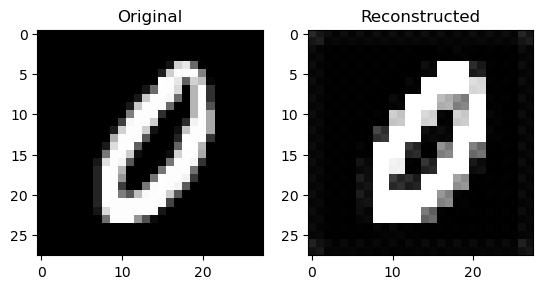

In [4]:
# Define the Autoencoder model
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            # torch.nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model, define the loss function and the optimizer
model = Autoencoder()
loss_fn = torch.nn.MSELoss()
optimizr = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 2 # 10
# outputs = []
for epoch in range(num_epochs):
    for data in dl:
        x_i, y_i = data
        yhat = model(x_i)
        loss = loss_fn(yhat, x_i)
        optimizr.zero_grad()
        loss.backward()
        optimizr.step()
        # print(f' y: {y_i.shape}')
        # print(f' x: {x_i.shape}')
        # print(f' yhat: {yhat.shape}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    # outputs.append((epoch, x_i, yhat))

# Testing the model
with torch.no_grad():
    for data in dl2:
        img, _ = data
        yhat = model(img)
        break

# Visualizing the original and reconstructed images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img[0].numpy().squeeze(), cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(yhat[0].numpy().squeeze(), cmap='gray')
axes[1].set_title('Reconstructed')
plt.show()
    

In [5]:
img[0].shape

torch.Size([1, 28, 28])

In [6]:
model.encoder(img[0]).shape

torch.Size([1, 14, 14])

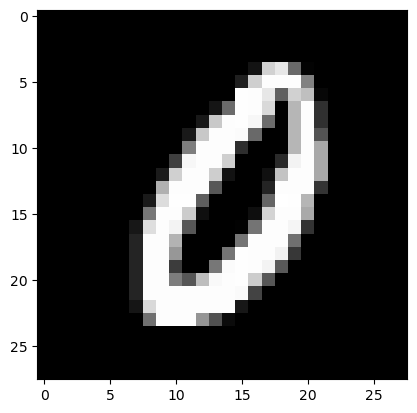

In [7]:
plt.imshow(torch.einsum('cij->ijc',img[0]).data , cmap="gray")

In [8]:
torch.einsum('cij->ijc',(model.encoder(img[0]))).shape

torch.Size([14, 14, 1])

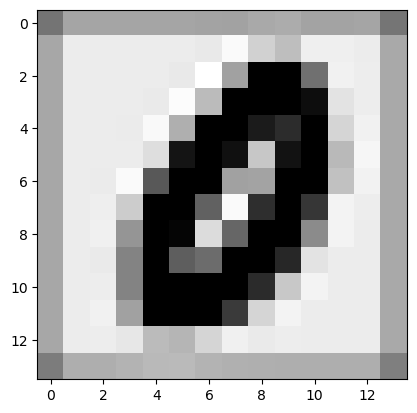

In [9]:
plt.imshow(torch.einsum('cij->ijc',(model.encoder(img[0]))).data, cmap="gray")

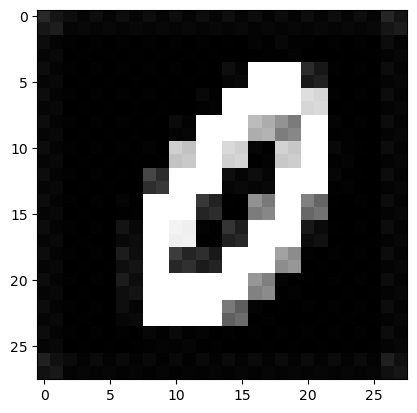

In [10]:
plt.imshow(torch.einsum('cij->ijc',model.decoder(model.encoder(img[0]))).data, cmap="gray")

In [11]:
import numpy as np 
import matplotlib.pyplot as plt

class DrawSin:
    def __init__(self,amp,freq,bias,end_time):
        self.amp=amp
        self.freq=freq
        self.bias=bias
        self.end_time=end_time
    def calc_sin(self):
        self.t = np.arange(0,self.end_time,0.01)
        return self.amp*np.sin(2*np.pi*self.freq*self.t)+self.bias
    def draw_sin(self):
        y=self.calc_sin()
        plt.figure(figsize=(12,6))
        plt.plot(self.t,y)
        plt.grid()
        plt.show()
        
class DrawSinusoidal(DrawSin):
    def calc_cos(self):
        self.t=np.arange(0,self.end_time,0.01)
        return self.amp*np.cos(2*np.pi*self.freq*self.t)+self.bias
    def draw_cos(self):
        y=self.calc_cos()
        plt.figure(figsize=(12,6))
        plt.plot(self.t,y)
        plt.grid()
        plt.show()

class DrawSinusoidal2(DrawSinusoidal):
    # 오버라이딩
    def draw_sin(self):
        y=self.calc_sin()
        plt.figure(figsize=(12,6))
        plt.plot(self.t,y)
        plt.title('Sin Graph')
        plt.ylabel('Sin')
        plt.xlabel('time (sec)')
        plt.grid()
        plt.show()

class DrawSinusoidal3(DrawSinusoidal2):
    def __init__(self,amp,freq,bias,end_time,ts):
        # self.amp=amp
        # self.freq=freq
        # self.bias=bias
        # self.end_time=end_time
        super().__init__(amp,freq,bias,end_time)
        # super(DrawSinusoidal3,self).__init__(amp,freq,bias,end_time) # 위 super이랑 동일한 효과
        self.ts = ts
        
    def calc_cos(self):
        self.t=np.arange(0,self.end_time,self.ts)
        return self.amp*np.cos(2*np.pi*self.freq*self.t)+self.bias
    def calc_sin(self):
        self.t = np.arange(0,self.end_time,self.ts)
        return self.amp*np.sin(2*np.pi*self.freq*self.t)+self.bias


In [12]:
# a =DrawSin(1,1,1,1)
# a.draw_sin()
# b =DrawSinusoidal(1,1,1,1)
d = DrawSinusoidal3(1,1,1,1,0.1)
d.__dict__

{'amp': 1, 'freq': 1, 'bias': 1, 'end_time': 1, 'ts': 0.1}

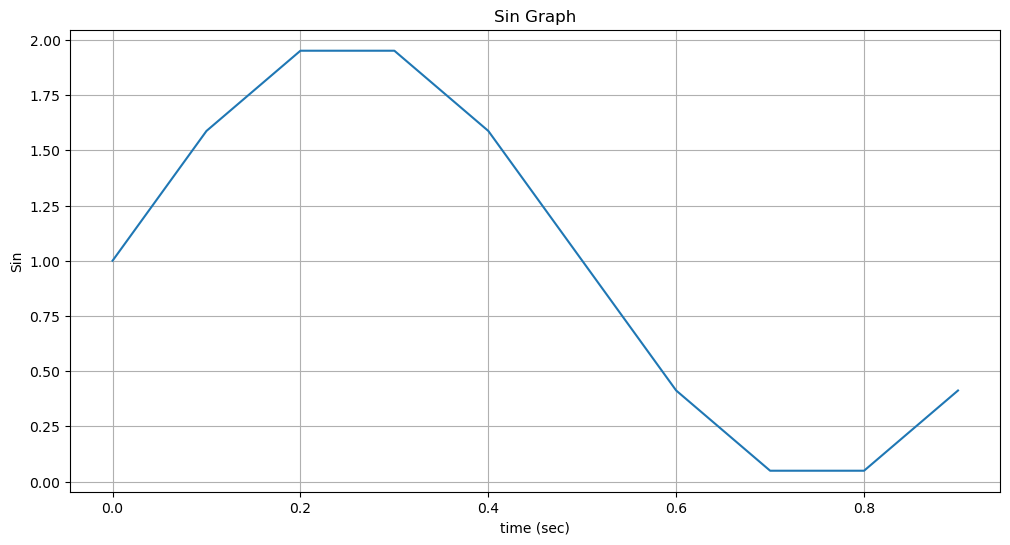

In [13]:
d.draw_sin()

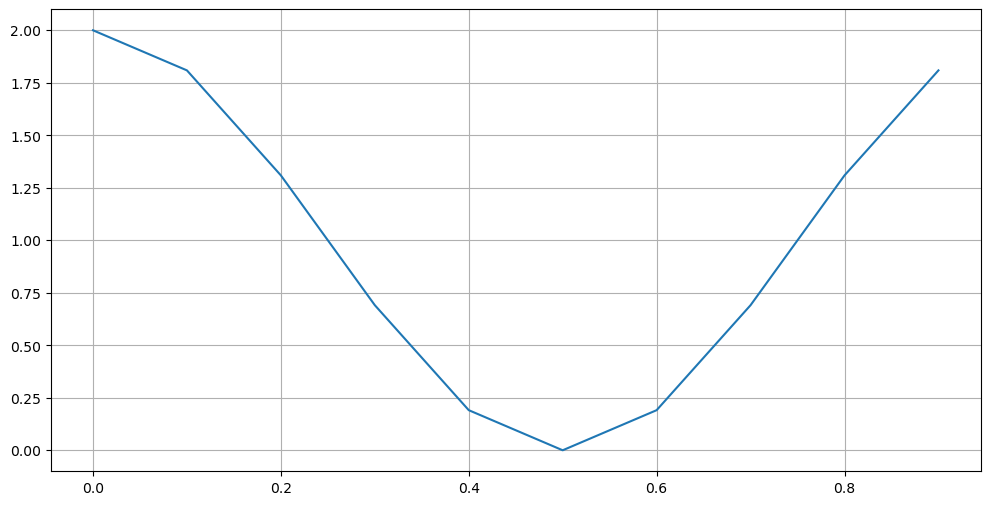

In [14]:
d.draw_cos()